In [ ]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pwd

/content


In [ ]:
!cd models/research && protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!cd models/research && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1697356 sha256=a15282c000828c5aa82f32795027d66fda48d455c6ae796b0394381d99f1a5dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-49d8vcgq/wheels/53/dd/70/2de274d6c443c69d367bd6a5606f95e5a6df61aacf1435ec0d
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
#!cd models/research && python object_detection/builders/model_builder_tf2_test.py

In [ ]:
import os
import tensorflow as tf
import pathlib

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

%matplotlib inline

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

File ‘walkingdog.jpeg’ already there; not retrieving.

File ‘traffic.jpeg’ already there; not retrieving.

File ‘jungle.jpeg’ already there; not retrieving.

File ‘intersection.jpeg’ already there; not retrieving.



In [ ]:
IMAGE_PATHS = ['intersection.jpeg', 'jungle.jpeg', 'traffic.jpeg', 'walkingdog.jpeg']

In [ ]:
url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz"

In [ ]:
PATH_TO_MODEL_DIR = tf.keras.utils.get_file(
    fname='ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
    origin=url,
    untar=True
)

In [ ]:
PATH_TO_MODEL_DIR

'/root/.keras/datasets/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'

In [ ]:
url = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt"

In [ ]:
PATH_TO_LABELS = tf.keras.utils.get_file(
    fname='mscoco_label_map.pbtxt',
    origin=url,
    untar=False
)

In [ ]:
# url = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt"
# PATH_TO_LABELS = tf.keras.utils.get_file(
#     fname="mscoco_label_map.pbtxt",
#     origin=url,
#     untar = False
# )
PATH_TO_LABELS = "../mscoco_label_map.pbtxt"

In [ ]:
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


In [ ]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + '/saved_model'

detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [ ]:
def load_img_as_arr(path_to_img):
  return np.asarray(Image.open(path_to_img))

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [ ]:
def detect_objects(image_path):

  input_img = load_img_as_arr(image_path)

  input_tensor = tf.convert_to_tensor(input_img)

  input_tensor = input_img[tf.newaxis, ...]

  detections = detect_fn(input_tensor)
  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections] for key, value in detections.items()}

  detections['num_detection'] = num_detections

  detections['detection_classes'] = detections['detection_classes'].numpy().astype(np.int64)

  unique_classes = set(detections['detection_classes'])
  print('Found classes: ')
  for c in unique_classes:
    print(category_index[c]['name'])

  image_with_detections = input_img.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index=category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.3,
      agnostic_mode=False
  )

  plt.figure(figsize=(15, 10))
  plt.imshow(image_with_detections)
  print('Done')
  plt.show()

Found classes: 
potted plant
person
bicycle
car
frisbee
motorcycle
bus
truck
traffic light
stop sign
parking meter
elephant
Done


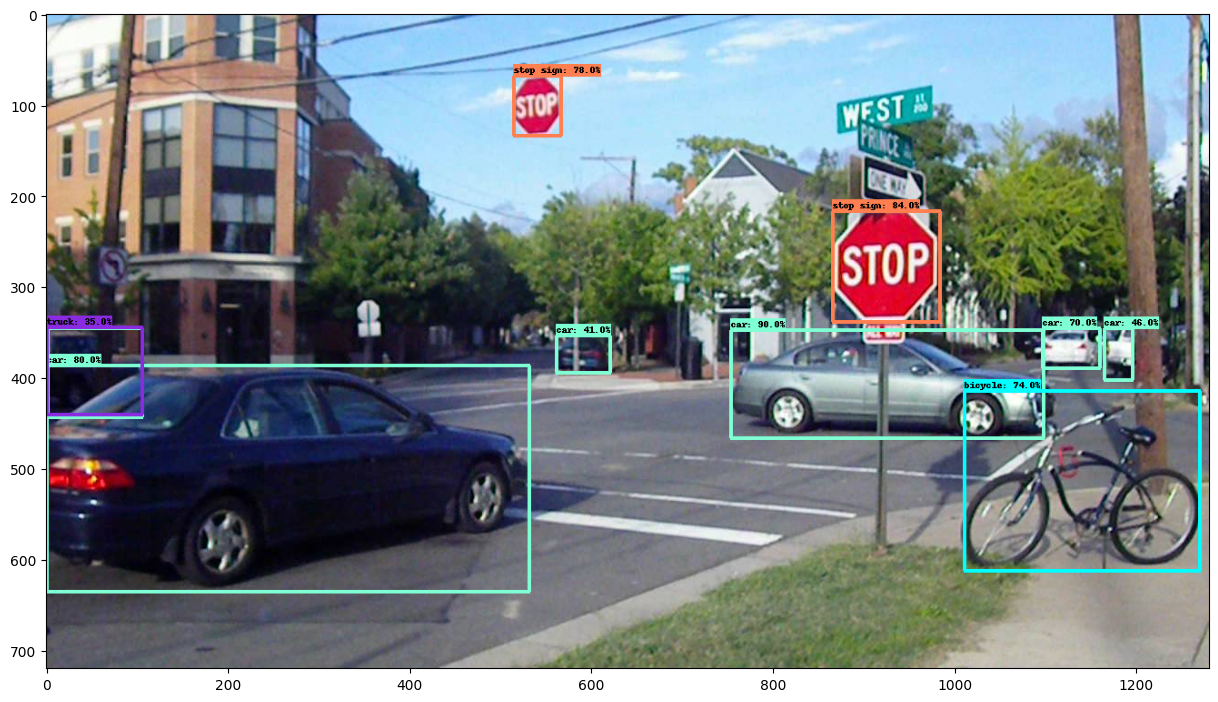

In [ ]:
detect_objects(IMAGE_PATHS[0])

Found classes: 
person
train
fire hydrant
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
sports ball
baseball glove
skateboard
surfboard
banana
sandwich
donut
cake
potted plant
toilet
teddy bear
Done


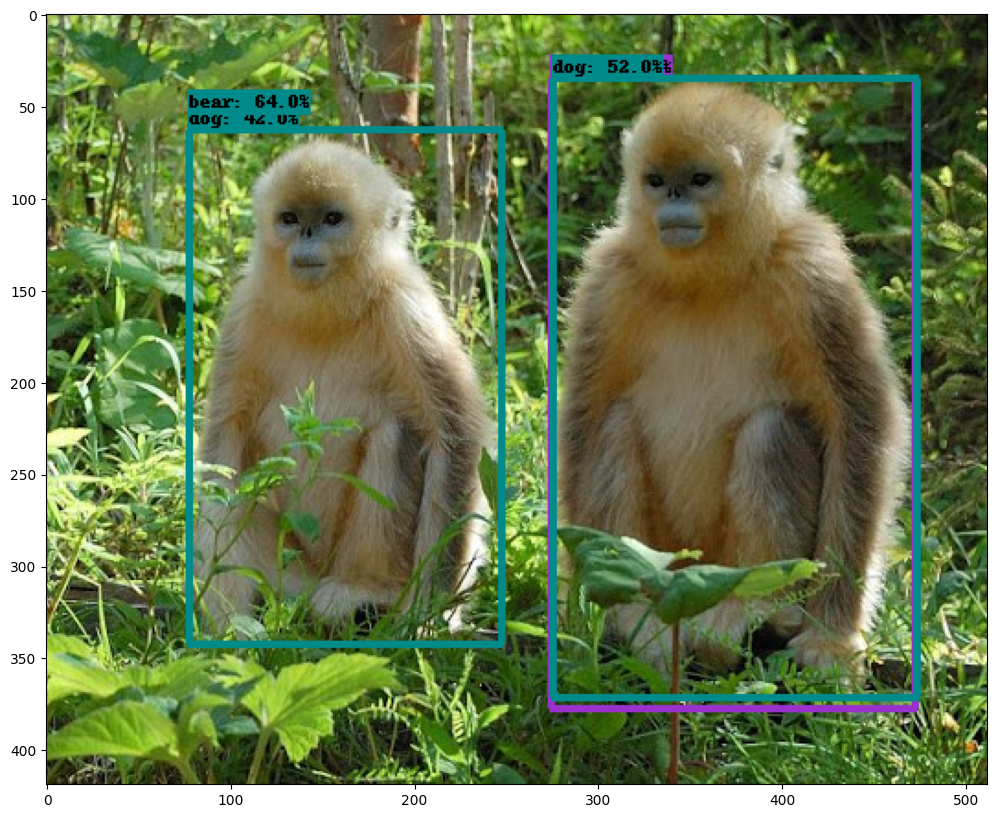

In [ ]:
detect_objects(IMAGE_PATHS[1])

Found classes: 
potted plant
person
bicycle
car
tie
bus
truck
vase
Done


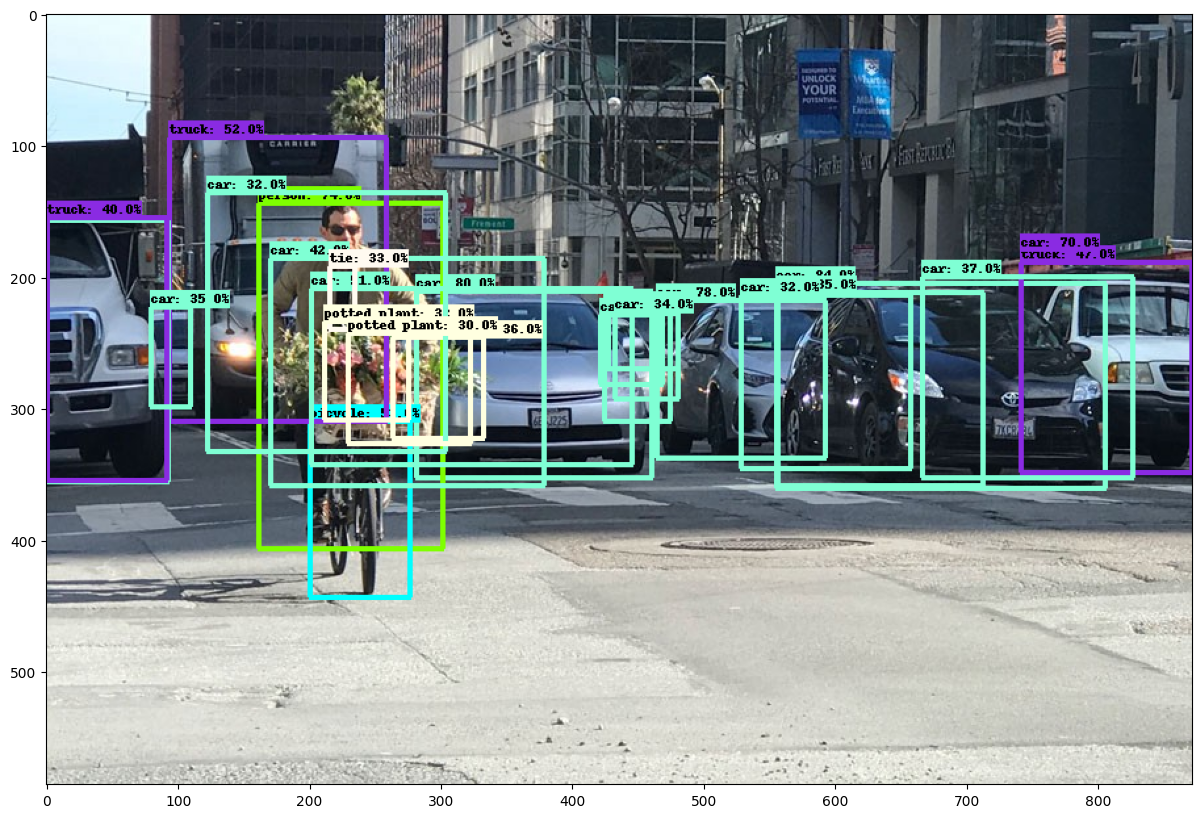

In [ ]:
detect_objects(IMAGE_PATHS[2])

Found classes: 
person
bench
cat
dog
horse
sheep
cow
bear
backpack
handbag
frisbee
sports ball
baseball bat
baseball glove
skateboard
tennis racket
bottle
wine glass
cup
potted plant
remote
cell phone
clock
Done


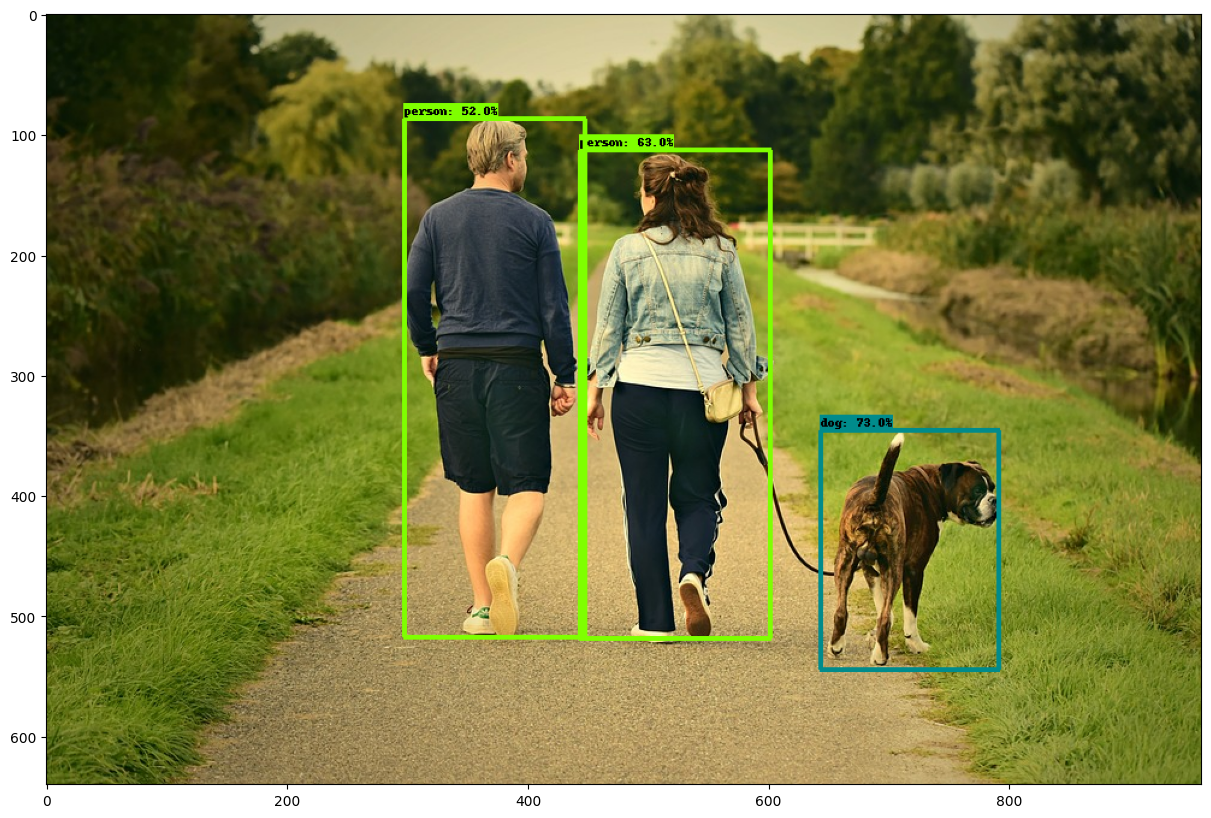

In [ ]:
detect_objects(IMAGE_PATHS[3])